## Импорты

In [0]:
# !pip3 install matplotlib tqdm numpy torch

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
from tqdm import tqdm_notebook, trange, tqdm
import pickle
import numpy as np
from IPython.display import clear_output
import jedi
import tokenize
from io import BytesIO
import timeit

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
device

device(type='cuda', index=0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_path = '/content/drive/My Drive/vkr'


* суммирую все эмбеддинги, которые встретил до текущего ключевого слова, конкатенирую к эмбеддингу текущего слова
    - итерируюсь по файлам из train_files.txt
    - иду с помощью tokenize + isidentifier(), выбираю из кода identifiers, которые есть в mapping.map
        - может ли регулярка возвращать индекс начала распознанного слова?
        - сохраняю в массив `[[identifier, index], [...], ...]`
    - предсохраняю номера токенов, которые войдут в сумму
    - подаю в jedi предыдущий код + первую букву identifier'а (индекс от регулярки + 1)
    - итерируюсь по предсказаниям и добавляю объекты в train такого вида:
    ```
    [
        arr_of_prev_tokens,
        predicted_token (число из mapping.map),
        real_token (число из mapping.map)
    ]```
    - дамплю в пикл `{file_name: train}`
* подаю на вход полносвязному слою
* беру сигмоиду
* подаю в кросс-энтропию

In [0]:
# times_dict = {
#     'code_read': [],
#     'tokenize': [],
#     'before_jedi': [],
#     'jedi': [],
#     'after_jedi': [],
#     'everything_in_for_in_g_body': [],
#     'save_preprocessed': [],
# }


# def prepare_samples(path, samples_path):
#     def get_filenames(path):
#         with open(path) as f:
#             filenames = f.read().split('\n')
#         return filenames
    
#     def load_mapping(path):
#         with open(path, 'rb') as f:
# #         print(base_path + '/mapping.map')
#             word_to_id = pickle.load(f)
#         return word_to_id

#     def predict_tokens(code):
#         try:
#             script = jedi.Script(code)
#             return script.completions()
#         except KeyError:
#             pass
# #             prepare_samples(path, samples_path)
    
#     def load_preprocessed(path):
#         try:
#             with open(path, 'rb') as f:
#                 samples = pickle.load(f)
#         except FileNotFoundError:
#             samples = {}
#         return samples
    
#     def save_preprocessed(samples_dict_path, samples_dict):
#         with open(samples_dict_path, 'wb') as f:
#             samples = pickle.dump(samples_dict, f)
    
#     filenames = get_filenames(path + samples_path)
#     word_to_id = load_mapping('./mapping.map')
    
#     samples_dict_path = './ranking_samples_' + samples_path[:3]
#     samples_dict = load_preprocessed(samples_dict_path)

# #     start_time = timeit.default_timer()
# #     # code you want to evaluate
# #     elapsed = timeit.default_timer() - start_time

#     for i, filename in enumerate(tqdm(filenames)):
        
#         if filename in samples_dict:
#             continue

# #         clear_output()
#         times_dict['code_read'].append(0.)
#         times_dict['tokenize'].append(0.)
#         times_dict['before_jedi'].append(0.)
#         times_dict['jedi'].append(0.)
#         times_dict['after_jedi'].append(0.)
#         times_dict['everything_in_for_in_g_body'].append(0.)
#         times_dict['save_preprocessed'].append(0.)

#         start_time = timeit.default_timer()
#         with open(path + filename) as f:
#             code = f.read()
#         times_dict['code_read'][-1] += timeit.default_timer() - start_time
#         print(times_dict['code_read'])
        
#         start_time = timeit.default_timer()
#         samples = []
#         prev_tokens = []
#         g = tokenize.tokenize(BytesIO(code.encode("utf-8")).readline)
#         code_lines = code.split('\n')
#         times_dict['tokenize'][-1] += timeit.default_timer() - start_time
#         print(times_dict['tokenize'])
        
#         start_time = timeit.default_timer()
#         for toktype, tokval, start, _, _ in g:
#             if toktype == tokenize.NAME and tokval in word_to_id:
#                 inner_start_time = timeit.default_timer()
#                 row, col = start
#                 real_token = word_to_id[tokval]
#                 prev_code = '\n'.join(code_lines[:row-1]) + '\n' + code_lines[row-1][:col+1]
#                 times_dict['before_jedi'][-1] += timeit.default_timer() - inner_start_time
                
#                 inner_start_time = timeit.default_timer()
#                 preds = predict_tokens(prev_code)
#                 times_dict['jedi'][-1] += timeit.default_timer() - inner_start_time

#                 inner_start_time = timeit.default_timer()
#                 for pred in preds:
#                     completion = pred.full_name
#                     if completion in word_to_id:
#                         completion_id = word_to_id[completion]
#                         samples.append([
#                             prev_tokens[:],
#                             completion_id,
#                             real_token
#                         ])
#                 prev_tokens.append(real_token)
#                 times_dict['after_jedi'][-1] += timeit.default_timer() - inner_start_time
# #                     break
#         times_dict['everything_in_for_in_g_body'][-1] += timeit.default_timer() - start_time
#         print(times_dict['everything_in_for_in_g_body'])
#         samples_dict[filename] = samples
        
#         start_time = timeit.default_timer()
#         save_preprocessed(samples_dict_path, samples_dict)
#         times_dict['save_preprocessed'][-1] += timeit.default_timer() - start_time
#         clear_output()
# #         break
#     save_preprocessed(samples_dict_path, samples_dict)
#     return samples_dict

# path = './pycodesuggest_py_repos_normalised/'
# samples_path = 'train_files.txt'
# samples = prepare_samples(path, samples_path)
        

In [0]:
# times_dict

In [0]:
with open(base_path + '/ranking_samples_tra', 'rb') as f:
    samples = pickle.load(f)

In [7]:
count = 0

for v in samples.values():
    count += len(v)
print(count)
print(len(samples.values()))

90017
126


## create test dataset

In [0]:
# jedi_correct = 900.0
# jedi_total = 5984.0

In [0]:
# def prepare_test_samples(path, samples_path):
#     global jedi_correct, jedi_total

#     def get_filenames(path):
#         with open(path) as f:
#             filenames = f.read().split('\n')
#         return filenames
    
#     def load_mapping(path):
#         with open(path, 'rb') as f:
# #         print(base_path + '/mapping.map')
#             word_to_id = pickle.load(f)
#         return word_to_id

#     def predict_tokens(code):
#         try:
#             script = jedi.Script(code)
#             return script.completions()
#         except KeyError:
#             pass
# #             prepare_samples(path, samples_path)

#     def save_preprocessed(samples_dict_path, samples_dict):
#         with open(samples_dict_path, 'wb') as f:
#             pickle.dump(samples_dict, f)
    
#     def load_preprocessed(path):
#         try:
#             with open(path, 'rb') as f:
#                 samples = pickle.load(f)
#         except FileNotFoundError:
#             samples = {}
#         return samples
    
#     def handle_identifier(toktype, tokval, start):
#         global jedi_correct, jedi_total
#         row, col = start
#         real_token = word_to_id[tokval]
#         prev_code = '\n'.join(code_lines[:row-1]) + '\n' + code_lines[row-1][:col+1]

#         preds = predict_tokens(prev_code)

#         for idx, pred in enumerate(preds):
#             completion = pred.full_name
#             if idx == 0:
#                 if completion == tokval:
#                     jedi_correct += 1
#                 jedi_total += 1
#             if completion in word_to_id:
#                 completion_id = word_to_id[completion]
#                 samples.append([
#                     prev_tokens[:],
#                     completion_id,
#                     real_token
#                 ])
#         prev_tokens.append(real_token)
    
#     filenames_for_test = get_filenames(path + samples_path)#[::-1]
#     word_to_id = load_mapping('./mapping.map')
    
#     samples_dict_path = './ranking_samples_' + samples_path[:3]
#     samples_dict = load_preprocessed(samples_dict_path)

#     for i, filename in enumerate(tqdm_notebook(filenames_for_test)):
        
#         if filename in samples_dict:
#             continue

#         with open(path + filename) as f:
#             code = f.read()
#         print(path + filename)

#         samples = []
#         prev_tokens = []
#         g = tokenize.tokenize(BytesIO(code.encode("utf-8")).readline)
#         code_lines = code.split('\n')

#         # todo accuracy plot
#         for toktype, tokval, start, _, _ in g:
#             if toktype == tokenize.NAME and tokval in word_to_id:
#                 handle_identifier(toktype, tokval, start)
        
#         samples_dict[filename] = samples

#         save_preprocessed(samples_dict_path, samples_dict)
#         clear_output()
#         print('Jedi accuracy: {}/{}={:.4f}'.format(jedi_correct, jedi_total, jedi_correct / jedi_total))
# #         break
#     save_preprocessed(samples_dict_path, samples_dict)
#     return samples_dict

# path = './pycodesuggest_py_repos_normalised/'
# samples_path = 'test_files.txt' # todo due to word_to_id may not work
# samples, jedi_ = prepare_test_samples(path, samples_path)
        

./pycodesuggest_py_repos_normalised/conda-forge/staged-recipes/.ci_support/compute_build_graph.py


InvalidPythonEnvironment: Could not get version information for '/usr/local/opt/python/bin/python3.7': BlockingIOError(35, 'Resource temporarily unavailable')

In [0]:
def load_preprocessed(path):
    try:
        with open(path, 'rb') as f:
            samples = pickle.load(f)
    except FileNotFoundError:
        samples = {}
    return samples

test_samples = load_preprocessed(base_path + '/ranking_samples_tes')

In [9]:
count = 0

for v in test_samples.values():
    count += len(v)
print(count)
print(len(test_samples.values()))

14606
79


# Model


* модель — Dense layer
* как обучаем: обрабатываем сохраненные в ranking_samples_tra данные, предлагаем слою по фичам (конкатенация текущего токена и сумма предыдущих + является ли текущий токен identfier) предсказать вероятность того, что это правильный токен
* как тестируем: делаем также, как и создавали обучающую выборку:  обновляем accuracy с каждым шагом (+ график accuracy)
* эмбеддинги слов, подаем конкатенацию суммы эмбеддингов и эмбеддинга текущего токена, предсказанного jedi; среди многих выбираем тот, в котором модель наиболее уверена

## training

In [0]:
def build_vocab():
    # load pre-computed vocab
    with open(base_path + '/mapping.map', 'rb') as f:
#         print(base_path + '/mapping.map')
        word_to_id = pickle.load(f)
    id_to_word = dict([(v, k) for (k, v) in word_to_id.items()])
    return word_to_id, id_to_word

word_to_id, id_to_word = build_vocab()


In [0]:
params = {
    'vocab_size': len(id_to_word),
    'emb_size': 100,
    'batch_size': 64
}

In [0]:
class DenseModel(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.embedding = nn.Embedding(
            self.params['vocab_size'] + 1,
            self.params['emb_size']
        )
        self.linear = nn.Linear(
            self.params['emb_size'] * 2,
            1
        )
        self.activation = nn.Sigmoid()

    def forward(self, prev_tokens, pred_token):
        if prev_tokens.shape[0] == 0:
            prev_tokens = torch.LongTensor([self.params['vocab_size']]).to(device)
#         print(prev_tokens)
        prev_embs = self.embedding(prev_tokens)
#         print(prev_embs)
#         print(prev_embs.shape)
        prev_embs_mean = torch.mean(prev_embs, dim=0)
        pred_emb = self.embedding(pred_token)
        pred_emb = torch.squeeze(pred_emb)
#         print(prev_embs_mean.shape)
#         print(pred_emb.shape)
        inputs = torch.cat((prev_embs_mean, pred_emb))
#         print(inputs.shape)
        output = self.linear(inputs)
#         print(output.shape)
        output = self.activation(output)
#         print(output.shape)
        return output



In [0]:
model = DenseModel(params).to(device)

In [0]:
class JediPredsDataset():
    def preprocess_data(self, filenames_to_data_dict):
        for data in filenames_to_data_dict.values():
            for prev_tokens, pred_token, real_token in data:
                self.prev_tokens_arr.append(np.array(prev_tokens))
                self.pred_token_arr.append(pred_token)
                self.real_token_arr.append(real_token)

    def __init__(self, path, params):
        self.index = 0
        self.prev_tokens_arr = []
        self.pred_token_arr = []
        self.real_token_arr = []

        with open(path, 'rb') as f:
            filenames_to_data_dict = pickle.load(f)
        self.preprocess_data(filenames_to_data_dict)
        self.prev_tokens_arr = np.array(self.prev_tokens_arr)
        self.pred_token_arr = np.array(self.pred_token_arr)
        self.real_token_arr = np.array(self.real_token_arr)
        # todo shuffle

    def __len__(self):
        return self.real_token_arr.shape[0]

    def generator(self):
        while self.index < self.__len__():
            yield \
                self.prev_tokens_arr[self.index], \
                self.pred_token_arr[self.index], \
                self.real_token_arr[self.index]
            self.index += 1

In [0]:


# train_loader = DataLoader(
#     JediPredsDataset('./ranking_samples_tra', params),
#     batch_size=params['batch_size'],
#     shuffle=True,
#     num_workers=10
# )

# train_data = JediPredsDataset(base_path + '/ranking_samples_tra', params)

In [21]:
# eq = 0
# neq = 0
# for prev_tokens, pred_token, real_token in train_data.generator():
#     if pred_token == real_token:
#         eq += 1
#     else:
#         neq += 1
# print(eq, neq, eq+neq)

7874 82143 90017


In [0]:
# next(train_data.generator())

In [0]:
# for i, (prev_tokens, pred_token, real_token) in zip(trange(len(train_data)), train_data.generator()):
#     print(1)
#     print(prev_tokens, pred_token, real_token)
#     print(2)
#     break

In [0]:
def train_epoch(model, optimizer, lr, train_data):
    loss_log = []
    model.train()
    total = 0
    correct = 0
    
    for i, (prev_tokens, pred_token, real_token) in zip(trange(len(train_data)), train_data.generator()):
        optimizer.zero_grad()
        prev_tokens = torch.LongTensor(prev_tokens).to(device)
        pred_token = torch.LongTensor([pred_token]).to(device)
        real_token = torch.FloatTensor([real_token]).to(device)
        loss_value = 0.
        loss = nn.BCELoss()
        output = model.forward(prev_tokens, pred_token)
        
#         print(real_token)
#         print(pred_token.float())
#         print(real_token == pred_token.float())
        loss_value = loss(output, (real_token == pred_token.float()).float())
        loss_value.backward()

#         torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
#         for p in model.parameters():
#             p.data.add_(-lr, p.grad.data)
        optimizer.step()
        loss_value = loss_value.item()
        loss_log.append(loss_value)# / x.shape[1])
#         break

#     accuracy = correct / total
#     return accuracy, loss_log
    return loss_log
    
def train(model, opt, n_epochs):
    train_log = []
    acc_log = []
    lr = 0.05
    lr_decay_base = 1 / 1.15
    m_flat_lr = 20.0
    for epoch in range(n_epochs):
        lr_decay = lr_decay_base ** max(epoch - m_flat_lr, 0)
        lr = lr * lr_decay
#         accuracy, train_loss = train_epoch(model, opt, lr)
        train_data = JediPredsDataset(base_path + '/ranking_samples_tra', params)
        train_loss = train_epoch(model, opt, lr, train_data)
        train_log.extend(train_loss)
#         acc_log.append(accuracy)
        clear_output()
        print("Epoch:{}".format(epoch))
#         print("Accuracy:", accuracy)
#         tp.send_text('Epoch {}, LSTM baseline accuracy: {}'.format(epoch, accuracy))
        plot_history(train_log)

def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Epoch:4


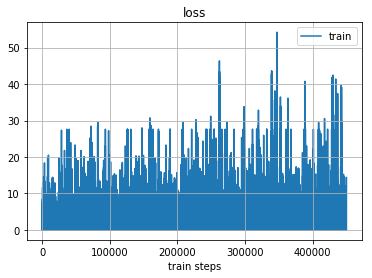

In [22]:
# %%time

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(model, optimizer, 5)

In [0]:
# prev_tokens, pred_token, _ = samples[0][0]
# model.eval()
# model.forward(torch.LongTensor(prev_tokens), torch.LongTensor([pred_token]))

tensor([8.0516e-07], grad_fn=<SigmoidBackward>)

### тестируем пошагово

# Test

In [0]:
test_data = JediPredsDataset(base_path + '/ranking_samples_tes', params)

In [0]:

def test(model):
    loss_log = []
    model.eval()
    total = 0
    correct = 0
    prev_prevtokens, prev_realtoken = None, None
    outputs = []
    for i, (prev_tokens, pred_token, real_token) in zip(trange(len(test_data)), test_data.generator()):
        prev_tokens_t = torch.LongTensor(prev_tokens).to(device)
        pred_token_t = torch.LongTensor([pred_token]).to(device)
#         real_token_t = torch.FloatTensor([real_token]).to(device)
        output = model.forward(prev_tokens_t, pred_token_t)

        if np.all(prev_tokens == prev_prevtokens) and \
                prev_realtoken == real_token:
            outputs.append([pred_token, output])
        else:
            if prev_realtoken is not None:
                max_prob = 0.
                pred = None
                for o in outputs:
                    if o[1] > max_prob:
                        max_prob = o[1]
                        pred = o[0]
                if pred == real_token:
                    correct += 1
                total += 1
            
            outputs = [[pred_token, output]]
            
            prev_prevtokens = prev_tokens
            prev_realtoken = real_token
                
#     accuracy = correct / total
    return correct, total

In [25]:
correct, total = test(model)
correct, total

  0%|          | 0/14606 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
100%|██████████| 14606/14606 [00:05<00:00, 2825.81it/s]


(26, 4068)

In [26]:
correct / total

0.006391347099311701

# Let's test test
Because ranking is quite bad (0.006 acc) while jedi is good (0.15 acc)

In [0]:

def test(model):
    loss_log = []
    model.eval()
    total = 0
    correct = 0
    prev_prevtokens, prev_realtoken = None, None
    test_data = JediPredsDataset(base_path + '/ranking_samples_tes', params)
    for i, (prev_tokens, pred_token, real_token) in zip(trange(len(test_data)), test_data.generator()):
        prev_tokens_t = torch.LongTensor(prev_tokens).to(device)
        pred_token_t = torch.LongTensor([pred_token]).to(device)
#         real_token_t = torch.FloatTensor([real_token]).to(device)
#         output = model.forward(prev_tokens_t, pred_token_t)

        if np.all(prev_tokens == prev_prevtokens) and \
                prev_realtoken == real_token:
            pass
        else:
            if prev_realtoken is not None:
                if pred_token == real_token:
                    correct += 1
                total += 1
            
            prev_prevtokens = prev_tokens
            prev_realtoken = real_token
                
#     accuracy = correct / total
    return correct, total

In [38]:
correct, total = test(model)
correct, total

  0%|          | 0/14606 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
100%|██████████| 14606/14606 [00:00<00:00, 17360.45it/s]


(601, 4068)

In [39]:
correct / total

0.14773844641101277

# Del

# Playing with jedi module

In [0]:
code = '''from __future__ import print_function
from socket import timeout
import os
import sys
import codecs
import re
import markdown
try:
    from urllib2 import urlopen
    from urllib2 import HTTPError
    from urllib2 import URLError
except ImportError:
    from urllib.request import urlopen
    from urllib.error import HTTPError
    from urllib.error import URLError


def function874(arg89):
    var4252 = False
    try:
        var4262 = urlopen(arg89, timeout=2)
        var4252 = var4262.code == 200
    except HTTPError as var3998:
        print(var3998, file=sys.stderr)
    except URLError as var3998:
        print(var3998, file=sys.stderr)
    except timeout as var3998:
        print(var3998, file=sys.stderr)
    except Exception as var3998:
        print(var3998, file=sys.stderr)
    return v'''

iter_num = 10
for i in range(iter_num):
    start_time = timeit.default_timer()
    script = jedi.Script(code)#source, 3, len('datetime.da'), 'example.py')
    elapsed_time = timeit.default_timer() - start_time
print(elapsed_time / iter_num)
script.completions()


0.013895298199986427


[<Completion: var3998>,
 <Completion: var4252>,
 <Completion: var4262>,
 <Completion: vars>]

In [0]:
code = '''
def foo(i):
'''

script = jedi.Script(code)#source, 3, len('datetime.da'), 'example.py')
script.completions()


[<Completion: abs>,
 <Completion: all>,
 <Completion: any>,
 <Completion: ArithmeticError>,
 <Completion: ascii>,
 <Completion: assert>,
 <Completion: AssertionError>,
 <Completion: async>,
 <Completion: AttributeError>,
 <Completion: await>,
 <Completion: BaseException>,
 <Completion: bin>,
 <Completion: BlockingIOError>,
 <Completion: bool>,
 <Completion: break>,
 <Completion: breakpoint>,
 <Completion: BrokenPipeError>,
 <Completion: BufferError>,
 <Completion: bytearray>,
 <Completion: bytes>,
 <Completion: BytesWarning>,
 <Completion: callable>,
 <Completion: ChildProcessError>,
 <Completion: chr>,
 <Completion: class>,
 <Completion: classmethod>,
 <Completion: compile>,
 <Completion: complex>,
 <Completion: ConnectionAbortedError>,
 <Completion: ConnectionError>,
 <Completion: ConnectionRefusedError>,
 <Completion: ConnectionResetError>,
 <Completion: continue>,
 <Completion: copyright>,
 <Completion: credits>,
 <Completion: def>,
 <Completion: del>,
 <Completion: delattr>,
 <Com

In [0]:
import tokenize
from io import BytesIO
from keyword import iskeyword

def load_code(path):
    pass

def process_code(code):
#     s = code #
    s = "def twoπ(a,b):"
    g = tokenize.tokenize(BytesIO(s.encode("utf-8")).readline)
    new_s = ''
    for toktype, tokval, st, end, _ in g:
        if toktype == tokenize.NAME:
            if iskeyword(tokval):
                print("KEYWORD", tokval, tokval.isidentifier(), st)
            else:
                print('NAME', tokval, tokval.isidentifier(), st)
        else:
            print(toktype, tokval)
        new_s += f'{tokval} '
    print(new_s)

process_code(None)

57 utf-8
KEYWORD def True (1, 0)
NAME twoπ True (1, 4)
53 (
NAME a True (1, 9)
53 ,
NAME b True (1, 11)
53 )
53 :
4 
0 
utf-8 def twoπ ( a , b ) :   


In [0]:
print(new_s[8:].strip())

def foo ( i ) : 
      f


In [0]:
script = jedi.Script(new_s[8:].strip())
script.completions()

[<Completion: filter>,
 <Completion: float>,
 <Completion: foo>,
 <Completion: for>,
 <Completion: format>,
 <Completion: from>,
 <Completion: frozenset>]